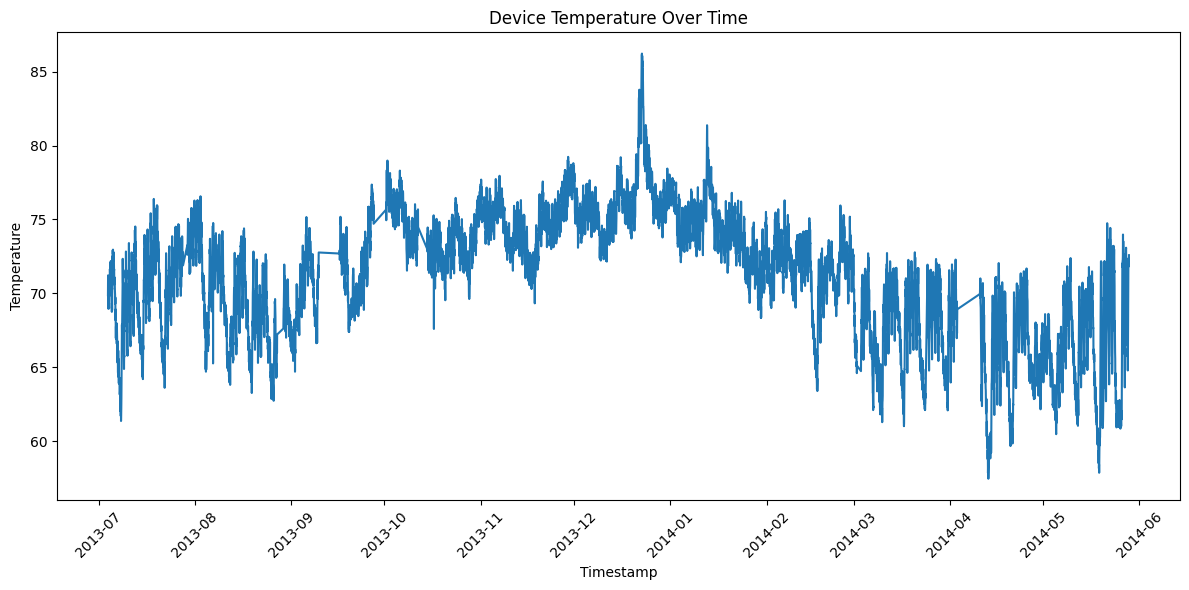

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

# Load the data
df = pd.read_csv('/content/temperature_device_failure.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create a basic time series plot
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'])
plt.title('Device Temperature Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**FEATURE ENGINEERING**

In [11]:
# Create 'dtcat' feature
df['hour'] = df['timestamp'].dt.hour
df['is_weekend'] = df['timestamp'].dt.dayofweek.isin([5, 6])

def categorize_time(row):
    if row['is_weekend']:
        return 'Weekend Night' if row['hour'] < 7 or row['hour'] >= 19 else 'Weekend Day'
    else:
        return 'Weekday Night' if row['hour'] < 7 or row['hour'] >= 19 else 'Weekday Day'

df['dtcat'] = df.apply(categorize_time, axis=1)

**CLUSTERING ANALYSIS**

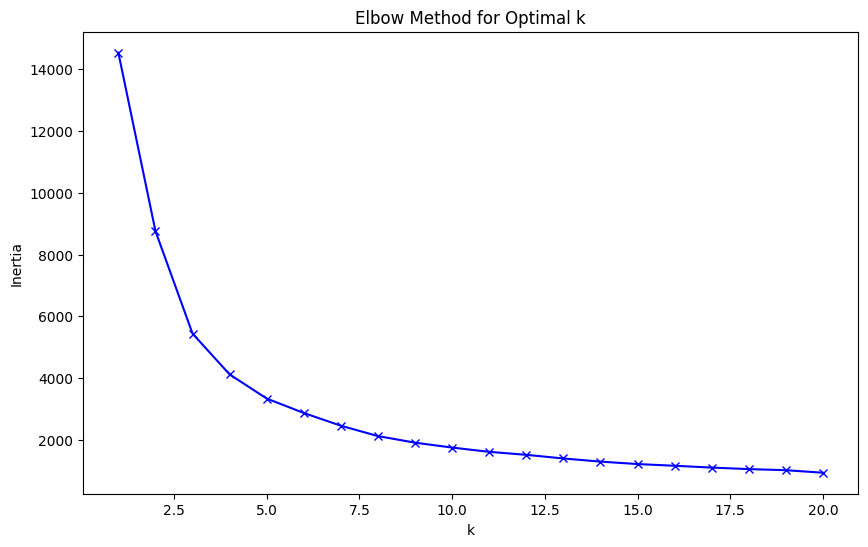

In [12]:
# We'll apply K-Means clustering and create an elbow plot to find the optimal number of clusters

# Prepare data for clustering
X = df[['value', 'hour']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow plot
inertias = []
K = range(1, 21)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

**Dimensionality Reduction & Visualization**

We'll use PCA to reduce the dataset to 2 dimensions and create a scatter plot of the clusters.


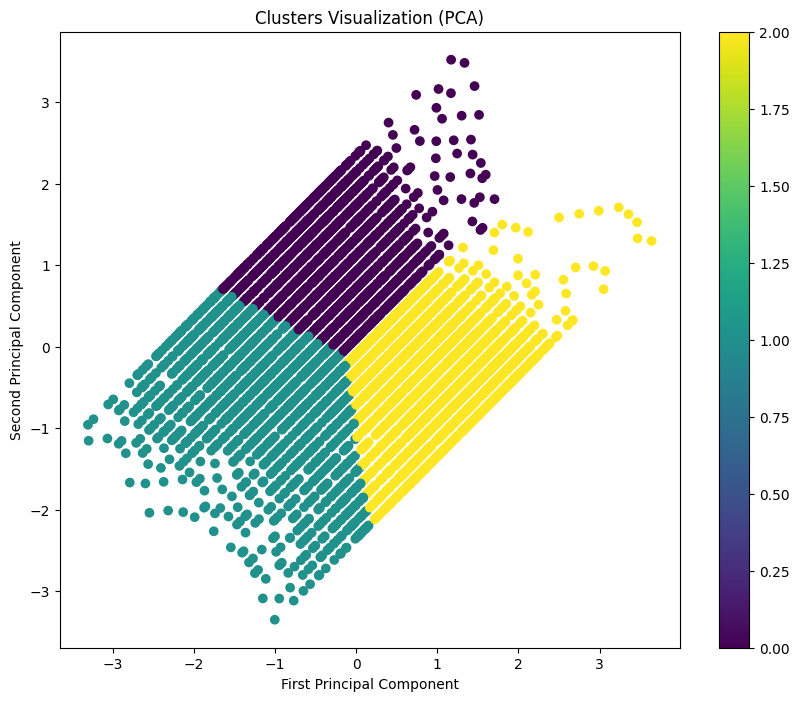

In [13]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply K-Means with optimal k (let's assume k=3 for this example)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis')
plt.title('Clusters Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

**ANOMALY DETECTION**


We'll apply two anomaly detection methods: Gaussian Distribution (EllipticEnvelope) and Isolation Forest.

In [14]:
def detect_anomalies(X, contamination, method='gaussian'):
    if method == 'gaussian':
        detector = EllipticEnvelope(contamination=contamination, random_state=42)
    else:
        detector = IsolationForest(contamination=contamination, random_state=42)

    return detector.fit_predict(X)

# Calculate IQR-based contamination
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
contamination_iqr = ((df['value'] < (Q1 - 1.5 * IQR)) | (df['value'] > (Q3 + 1.5 * IQR))).mean()

# Detect anomalies
df['anomaly_gaussian_1'] = detect_anomalies(X_scaled, contamination=0.01, method='gaussian')
df['anomaly_gaussian_iqr'] = detect_anomalies(X_scaled, contamination=contamination_iqr, method='gaussian')
df['anomaly_iforest_1'] = detect_anomalies(X_scaled, contamination=0.01, method='iforest')
df['anomaly_iforest_iqr'] = detect_anomalies(X_scaled, contamination=contamination_iqr, method='iforest')

**COMPARISION AND EVALUATION**

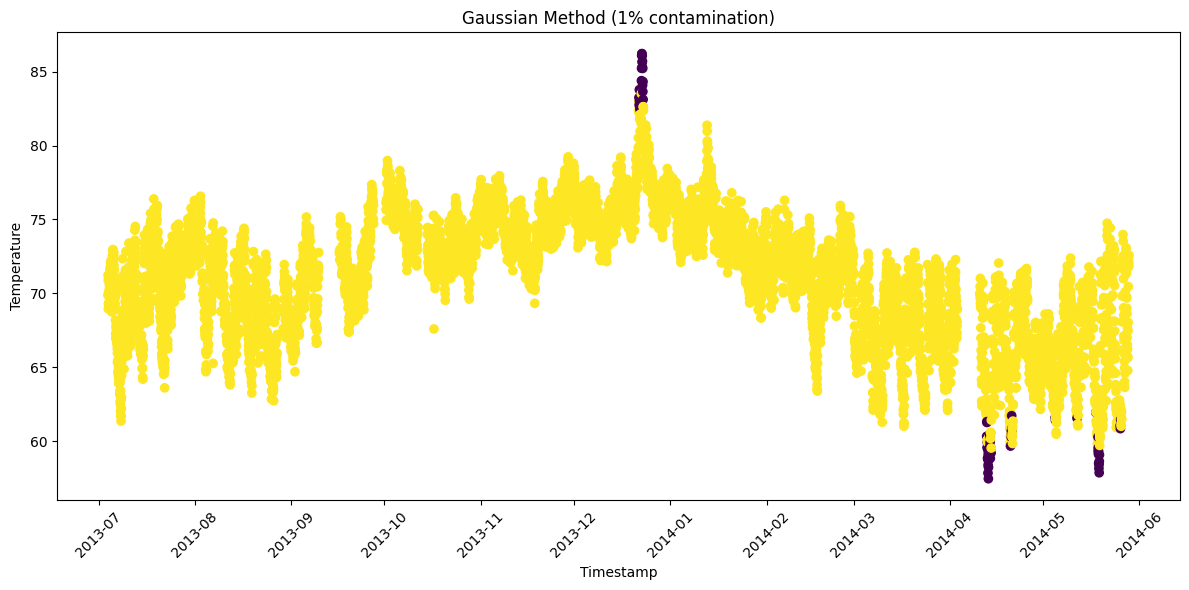

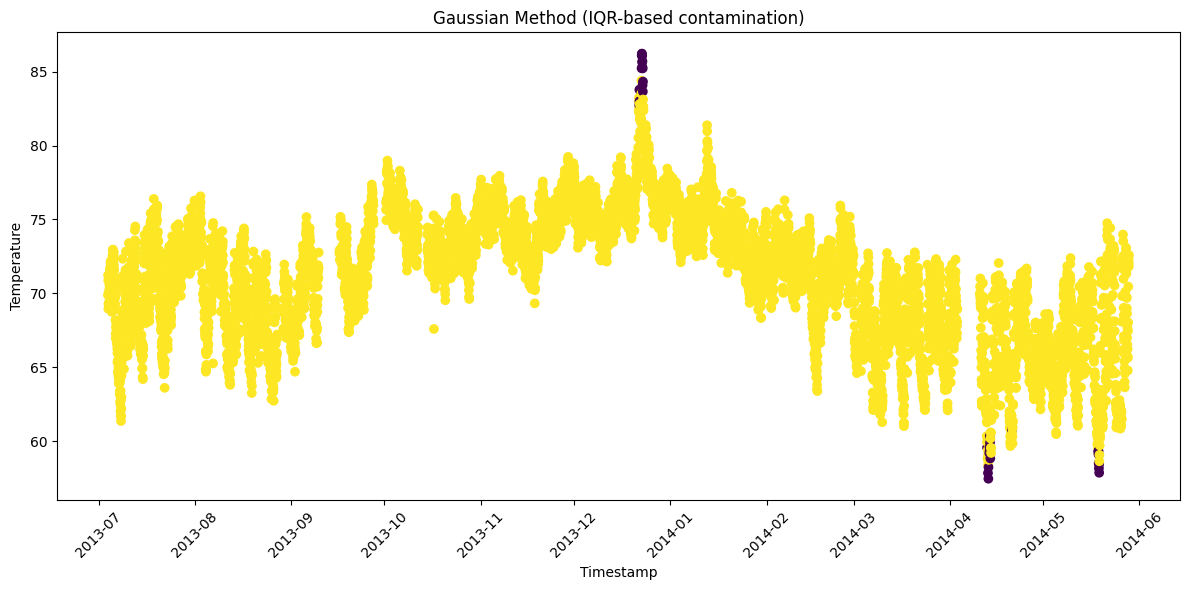

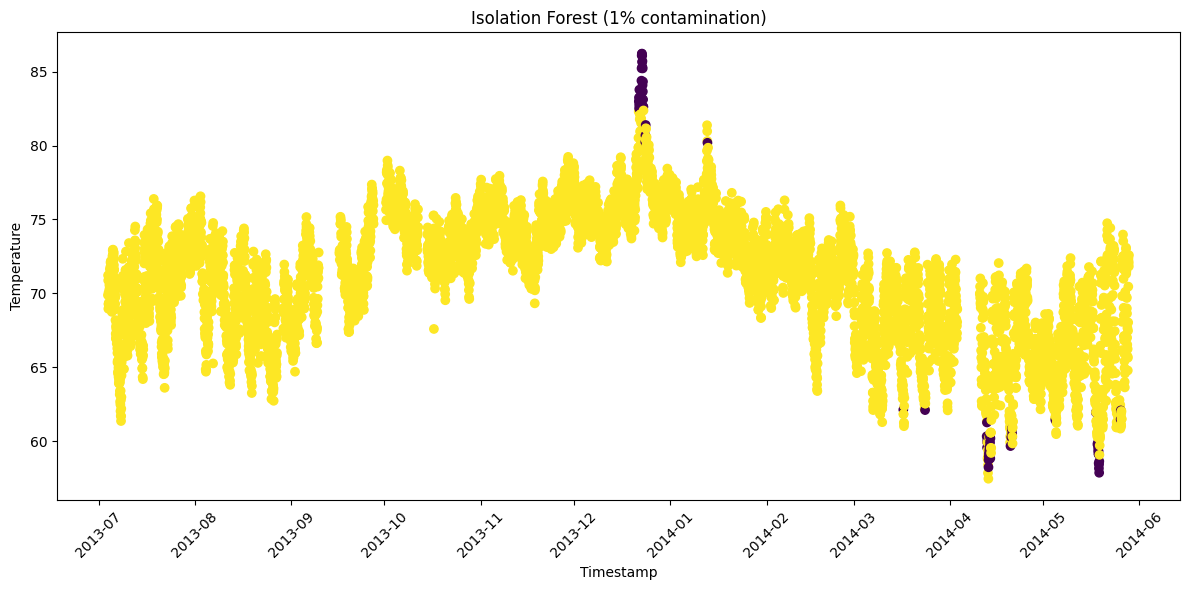

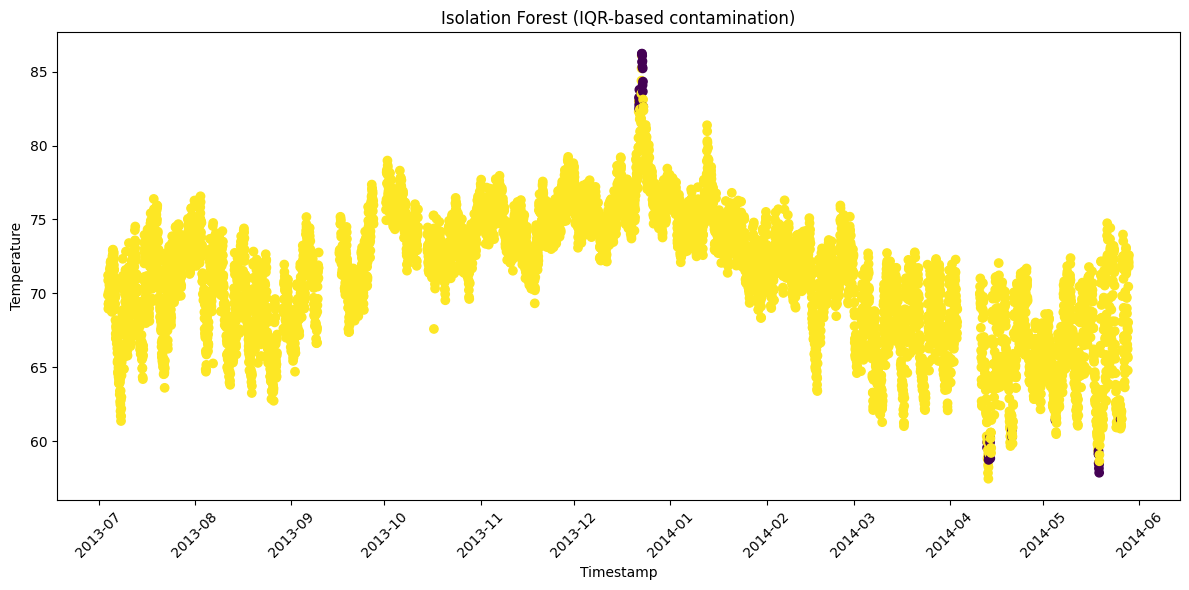

anomaly_gaussian_1: 73 anomalies detected
anomaly_gaussian_iqr: 35 anomalies detected
anomaly_iforest_1: 73 anomalies detected
anomaly_iforest_iqr: 35 anomalies detected

Anomalies by category (anomaly_gaussian_1):
dtcat
Weekend Night    0.575342
Weekend Day      0.232877
Weekday Night    0.191781
Name: proportion, dtype: float64

Anomalies by category (anomaly_gaussian_iqr):
dtcat
Weekend Night    0.571429
Weekday Night    0.257143
Weekend Day      0.171429
Name: proportion, dtype: float64

Anomalies by category (anomaly_iforest_1):
dtcat
Weekend Night    0.452055
Weekday Night    0.287671
Weekend Day      0.232877
Weekday Day      0.027397
Name: proportion, dtype: float64

Anomalies by category (anomaly_iforest_iqr):
dtcat
Weekend Night    0.628571
Weekday Night    0.285714
Weekend Day      0.057143
Weekday Day      0.028571
Name: proportion, dtype: float64


In [15]:
# Comparing both anomaly detection methods.
# Visualize anomalies
def plot_anomalies(anomaly_col, title):
    plt.figure(figsize=(12, 6))
    plt.scatter(df['timestamp'], df['value'], c=df[anomaly_col], cmap='viridis')
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_anomalies('anomaly_gaussian_1', 'Gaussian Method (1% contamination)')
plot_anomalies('anomaly_gaussian_iqr', 'Gaussian Method (IQR-based contamination)')
plot_anomalies('anomaly_iforest_1', 'Isolation Forest (1% contamination)')
plot_anomalies('anomaly_iforest_iqr', 'Isolation Forest (IQR-based contamination)')

# Compare anomaly detection results
anomaly_cols = ['anomaly_gaussian_1', 'anomaly_gaussian_iqr', 'anomaly_iforest_1', 'anomaly_iforest_iqr']
for col in anomaly_cols:
    print(f"{col}: {(df[col] == -1).sum()} anomalies detected")

# Analyze anomalies by dtcat
for col in anomaly_cols:
    print(f"\nAnomalies by category ({col}):")
    print(df[df[col] == -1]['dtcat'].value_counts(normalize=True))

**Conclusion:**
Based on these considerations, the Isolation Forest method appears to perform slightly better at identifying unusual device behavior. Its ability to detect anomalies during Weekday Days, which the Gaussian method missed, suggests it might be more sensitive to subtle deviations in device behavior. Additionally, its robustness to different data distributions and outliers makes it well-suited for analyzing complex device temperature patterns.
However, it's important to note that the performance difference is not dramatic, and both methods show similar overall patterns. For a comprehensive anomaly detection system, it might be beneficial to use both methods in conjunction, as they each have their strengths. The Gaussian method could be useful for detecting anomalies that follow a more predictable pattern, while the Isolation Forest could catch more subtle or unexpected deviations in device behavior.
To further improve the anomaly detection process, consider:
Incorporating additional features or contextual information about the device's operation.
Experimenting with other advanced techniques like Local Outlier Factor (LOF) or One-Class SVM5.
Conducting a more in-depth analysis of the nature and severity of the detected anomalies to refine the detection criteria.

Interpretation of Results
Number of Anomalies Detected
Both Gaussian and Isolation Forest methods detected the same number of anomalies for each contamination rate:
73 anomalies with 1% contamination rate
35 anomalies with IQR-based contamination rate
The IQR-based contamination rate resulted in fewer anomalies, suggesting it might be more conservative in identifying outliers.
Anomalies by Category
1. Gaussian Method (1% contamination)
Weekend Night: 57.5%
Weekend Day: 23.3%
Weekday Night: 19.2%
2. Gaussian Method (IQR-based contamination)
Weekend Night: 57.1%
Weekday Night: 25.7%
Weekend Day: 17.1%
3. Isolation Forest (1% contamination)
Weekend Night: 45.2%
Weekday Night: 28.8%
Weekend Day: 23.3%
Weekday Day: 2.7%
4. Isolation Forest (IQR-based contamination)
Weekend Night: 62.9%
Weekday Night: 28.6%
Weekend Day: 5.7%
Weekday Day: 2.9%
Key Findings
Weekend Night Dominance: Across all methods, Weekend Nights show the highest proportion of anomalies, ranging from 45.2% to 62.9%. This suggests that the device is most likely to experience temperature-related issues during weekend nights.
Night-time Vulnerability: Both Weekday and Weekend nights consistently show high proportions of anomalies. This indicates that the device is more prone to temperature anomalies during night hours, regardless of whether it's a weekday or weekend.
Weekend vs. Weekday: Weekends (both day and night) generally show higher anomaly rates compared to weekdays. This could indicate different operational conditions or reduced monitoring during weekends.
Weekday Day Stability: Weekday Days show the lowest proportion of anomalies across all methods, with only the Isolation Forest method detecting a small percentage (2.7% - 2.9%) of anomalies during this period. This suggests that the device operates most stably during regular working hours on weekdays.
Method Consistency: Both Gaussian and Isolation Forest methods show similar patterns in anomaly distribution, which increases confidence in the findings.
Recommendations for Maintenance Teams
Focus on Weekend Nights: Prioritize monitoring and preventive maintenance during weekend nights, as this is when the device is most likely to experience temperature-related issues.
Night-time Monitoring: Implement enhanced monitoring or automated alert systems for night-time operations, both on weekdays and weekends.
Weekend Operations Review: Investigate the reasons for higher anomaly rates during weekends. This could involve reviewing operational procedures, staffing levels, or environmental factors that might differ from weekdays.
Preventive Measures: Consider implementing additional cooling or temperature control measures that activate during night hours and weekends.
Regular Weekday Checks: While weekday days show the least anomalies, continue regular maintenance checks during these times to maintain the device's stability.
Further Investigation: Conduct a deeper analysis into the nature of these temperature anomalies, particularly focusing on the severity and duration during the high-risk periods identified.
By implementing these recommendations, the maintenance team can develop a more targeted approach to prevent temperature-related issues, potentially improving the device's reliability and performance, especially during the identified high-risk periods.